In [1]:
import sys, os
import pandas as pd
%matplotlib inline

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import datetime

DATE = lambda: datetime.datetime.now().strftime("[%m/%d/%Y %H:%M:%S]")


def tune_elasticnet(X_train_, y_train_, rand_seed_, log_grid_, n_core=6):
    """tune elasticnet model one round"""
    log_estimator = LogisticRegression(solver='saga',
                                       penalty='elasticnet',
                                       random_state=rand_seed_)

    log_model = GridSearchCV(estimator=log_estimator,
                             param_grid=log_grid_,
                             verbose=0,
                             n_jobs=n_core,
                             cv=3,
                             scoring='accuracy')

    log_model.fit(X_train_, np.ravel(y_train_))

    return log_model

# labels

In [2]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('../data_processed/meta_data.csv', index_col=1)
print(y.shape)
y = y[[ 'Day Post-Infection']]

# merge adult and aged group
y['stage'] = [
    'early' if i in [2.0, 1.0, 0.5] else 'late'
    for i in y['Day Post-Infection']
]
# y['stage'].value_counts()

y = y.replace({'early': 0, 'late': 1})
labels = ['early', 'late']  # for plotting convenience later on
y[['Day Post-Infection', 'stage']].value_counts()


X = pd.read_csv('../data_processed/plot_dat.csv', index_col=0).T
print(X.shape)

X.head(1)
all(X.index == y.index)

(74, 23)
(74, 10564)


True

class BootstrapRun:
    """A bootstrap run object"""
    def __init__(self,split_rand_seed,test_index_set):
        self.split_rand_seed =split_rand_seed
        self.test_index_set =  

# bootstrap

In [78]:
# split train and testing
from sklearn.model_selection import train_test_split
import random

n_keep = 1
n_try = 1
test_idx_set_dict = {}
init_seed = 200
random.seed(a=init_seed, version=2)
while n_keep <= 100:
    rand_seed = random.randrange(1000, )
    print("try {0}: rand seed={1}, recorded sets={2}.".format(
        n_try, rand_seed, n_keep))
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=rand_seed,
                                                        stratify=y)
    if (set(y_test.index) not in test_idx_set_dict.values()):
        n_keep += 1
        test_idx_set_dict[rand_seed] = set(y_test.index)
    n_try += 1

try 1: rand seed=46, recorded sets=1.
try 2: rand seed=923, recorded sets=2.
try 3: rand seed=208, recorded sets=3.
try 4: rand seed=752, recorded sets=4.
try 5: rand seed=726, recorded sets=5.
try 6: rand seed=31, recorded sets=6.
try 7: rand seed=146, recorded sets=7.
try 8: rand seed=632, recorded sets=8.
try 9: rand seed=880, recorded sets=9.
try 10: rand seed=817, recorded sets=10.
try 11: rand seed=273, recorded sets=11.
try 12: rand seed=938, recorded sets=12.
try 13: rand seed=11, recorded sets=13.
try 14: rand seed=708, recorded sets=14.
try 15: rand seed=450, recorded sets=15.
try 16: rand seed=726, recorded sets=16.
try 17: rand seed=171, recorded sets=16.
try 18: rand seed=735, recorded sets=17.
try 19: rand seed=16, recorded sets=18.
try 20: rand seed=449, recorded sets=19.
try 21: rand seed=284, recorded sets=20.
try 22: rand seed=449, recorded sets=21.
try 23: rand seed=470, recorded sets=21.
try 24: rand seed=237, recorded sets=22.
try 25: rand seed=197, recorded sets=2

In [79]:
%%time
import warnings

warnings.filterwarnings('ignore')

log_grid = [{
    'C': [1e-4, 1e-03, 1e-2, 1e-1, 1, 10],
    'l1_ratio': [0.2, 0.4, .6, .8, 1.0],
}]

split_rand_seeds = list(test_idx_set_dict.keys())
features_list = []
test_accuracy_scores = []
model_tune_history = []

print(DATE(), "=== Starting {0} bootstraps ===".format(len(split_rand_seeds)))
for i in range(len(split_rand_seeds)):
    if i % 5 == 0:
        print(DATE(), "running bootstrap #{}".format(i))
    rnd_seed = split_rand_seeds[i]
    test_idx_set = test_idx_set_dict[rnd_seed]
    train_idx_set = set(X.index) - test_idx_set
    X_train = X.loc[train_idx_set]
    y_train = y.loc[train_idx_set, ['stage']]
    X_test = X.loc[test_idx_set]
    y_test = y.loc[test_idx_set, ['stage']]

    log_model = tune_elasticnet(X_train,
                                y_train,
                                rnd_seed,
                                log_grid,
                                n_core=10)
    model_tune_history.append(log_model)

    #print("Best Parameters:\n", log_model.best_params_)

    # Select best log model
    best_log = log_model.best_estimator_

    # Make predictions using the optimised parameters
    log_pred = best_log.predict(X_test)
    test_accuracy_scores.append(
        [log_model.best_score_,
         accuracy_score(y_test, log_pred)])
    #     cm_log = confusion_matrix(y_test, log_pred)

    #features
    idx = np.where(np.ravel(best_log.coef_) != 0)
    features_list.append(
        pd.DataFrame({
            "gene": X.columns[idx],
            "coef": np.ravel(best_log.coef_)[idx]
        }).sort_values('coef', ascending=False))

[06/02/2021 11:10:57] === Starting 100 bootstraps ===
[06/02/2021 11:10:57] running bootstrap #0
[06/02/2021 11:11:30] running bootstrap #5
[06/02/2021 11:12:02] running bootstrap #10
[06/02/2021 11:12:33] running bootstrap #15
[06/02/2021 11:13:05] running bootstrap #20
[06/02/2021 11:13:38] running bootstrap #25
[06/02/2021 11:14:12] running bootstrap #30
[06/02/2021 11:14:46] running bootstrap #35
[06/02/2021 11:15:20] running bootstrap #40
[06/02/2021 11:15:54] running bootstrap #45
[06/02/2021 11:16:27] running bootstrap #50
[06/02/2021 11:16:59] running bootstrap #55
[06/02/2021 11:17:33] running bootstrap #60
[06/02/2021 11:18:05] running bootstrap #65
[06/02/2021 11:18:40] running bootstrap #70
[06/02/2021 11:19:12] running bootstrap #75
[06/02/2021 11:19:44] running bootstrap #80
[06/02/2021 11:20:16] running bootstrap #85
[06/02/2021 11:20:49] running bootstrap #90
[06/02/2021 11:21:22] running bootstrap #95
CPU times: user 2min 12s, sys: 7.21 s, total: 2min 20s
Wall time: 10

# Summarize data

In [80]:
%%time

# store weights vector to dict
feature_weight_dict = {
    g: [0 for i in range(100)]
    for g in list(set().union(
        *list(map(lambda x: set(x.gene), features_list))))
}

for i, l in enumerate(features_list):
    for _, row in l.iterrows():
        feature_weight_dict[row['gene']][i] = row['coef']

CPU times: user 19 s, sys: 116 ms, total: 19.1 s
Wall time: 18.8 s


%%time
feature_count_dict={g:0 for g in list(set().union(*list(map(lambda x: set(x.gene),features_list))))}
feature_weight_dict= feature_count_dict.copy()

for l in features_list:
    for _, row in l.iterrows():       
        feature_count_dict[row['gene']]+=1
        feature_weight_dict[row['gene']]+=row['coef']
        

df_feature_genes = pd.DataFrame.from_dict(
    feature_count_dict.items()).rename(columns={
        0: 'gene',
        1: 'counts'
    }).set_index('gene').sort_values('counts', ascending=False)

df_feature_genes= df_feature_genes.join(
    pd.DataFrame.from_dict(feature_weight_dict.items()).rename(columns={
        0: 'gene',
        1: 'avg_weights'
    }).set_index('gene'))


# add std
df_feature_genes['weight_std'] = [
    np.std(feature_weight_dict[g]) * 100
    for g, _ in df_feature_genes.iterrows()
]
df_feature_genes.head()

In [81]:
df_feature_genes = pd.DataFrame({
    'gene': [g for g in feature_weight_dict.keys()],
    'counts': [np.sum(np.array(v) != 0) for v in feature_weight_dict.values()],
    'avg_weight': [np.sum(np.array(v)) for v in feature_weight_dict.values()],
    'std_weight':
    [np.std(np.array(v)) * 100 for v in feature_weight_dict.values()],
}).set_index('gene').sort_values('avg_weight', ascending=False)

In [85]:
df_feature_genes[df_feature_genes.counts>=90].shape[0]

21

In [86]:
df_feature_genes[df_feature_genes.counts>=90].sort_values('avg_weight')

,counts,avg_weight,std_weight
gene,,,
Adm,100,-0.120850,0.088089
Mbd1,99,-0.102491,0.059782
Il1a,95,-0.088117,0.051090
Wnk3,91,-0.085383,0.050909
Gbp2b,96,-0.075573,0.039548
Znfx1,90,-0.053829,0.031713
Pbk,90,0.040893,0.020164
Cdk1,96,0.043823,0.018997
Birc5,98,0.045256,0.017206


# save

In [97]:
import pickle

bootstrap_result_dict = {
    'model_tune_history': model_tune_history,
    'test_accuracy_scores': test_accuracy_scores,
    'features_list': features_list,
    'init_random_seed': init_seed,
}
pickle.dump(bootstrap_result_dict, open('bootstrap_result_dict.p', 'wb'),
            pickle.HIGHEST_PROTOCOL)

In [101]:
df_feature_genes.sort_values('avg_weight').to_csv('bootstrap_features.csv')
df_feature_genes[df_feature_genes.counts >= 90].sort_values(
    'avg_weight').to_csv('bootstrap_features_selected.csv')

# plot 

## accuracy 

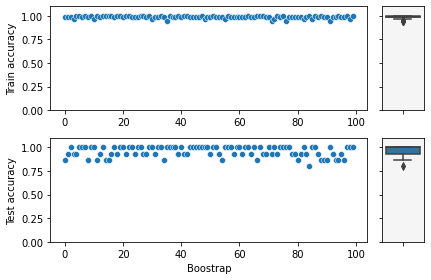

In [96]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(
    2,
    2,
    #                       figsize=(9,5),
    sharey=True,
    gridspec_kw=dict(width_ratios=[3, 0.4]))

ax = sns.scatterplot(x=list(range(len(test_accuracy_scores))),
                     ax=axs[0, 0],
                     y=[i[0] for i in test_accuracy_scores])

ax.set_ylim(0, 1.1)
ax.set_ylabel('Train accuracy')
ax = sns.boxplot(y=[i[0] for i in test_accuracy_scores], ax=axs[0, 1])
ax.set_facecolor('whitesmoke')

ax = sns.scatterplot(x=list(range(len(test_accuracy_scores))),
                     ax=axs[1, 0],
                     y=[i[1] for i in test_accuracy_scores])

ax.set_ylim(0, 1.1)
ax.set_ylabel('Test accuracy')
ax.set_xlabel('Boostrap')

ax = sns.boxplot(y=[i[1] for i in test_accuracy_scores], ax=axs[1, 1])
ax.set_facecolor('whitesmoke')

f.tight_layout()

## n features 

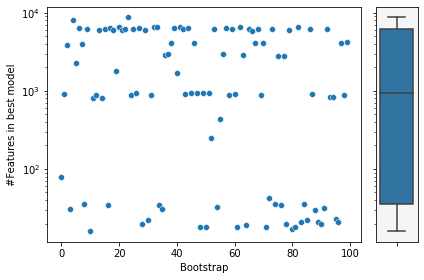

In [127]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(
    1,
    2,
    #                       figsize=(9,5),
    sharey=True,
    gridspec_kw=dict(width_ratios=[3, 0.4]))

ax = sns.scatterplot(x=list(range(len(test_accuracy_scores))),
                     ax=axs[0],
                     y=list(map(len, features_list)))

ax.set_ylabel('#Features in best model')
ax.set_yscale('log')
ax.set_xlabel('Bootstrap')

ax = sns.boxplot(y=list(map(len, features_list)), ax=axs[1])
ax.set_facecolor('whitesmoke')

f.tight_layout()